# Notebook for generating and saving SBM PATTERN graphs

In [1]:
import numpy as np
import torch
import pickle
import time

%matplotlib inline
import matplotlib.pyplot as plt
import scipy.sparse


# Generate SBM PATTERN graphs

In [2]:

def schuffle(W,c):
    # relabel the vertices at random
    idx=np.random.permutation( W.shape[0] )
    #idx2=np.argsort(idx) # for index ordering wrt classes
    W_new=W[idx,:]
    W_new=W_new[:,idx]
    c_new=c[idx]
    return W_new , c_new , idx 


def block_model(c,p,q):
    n=len(c)
    W=np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            if c[i]==c[j]:
                prob=p
            else:
                prob=q
            if np.random.binomial(1,prob)==1:
                W[i,j]=1
                W[j,i]=1     
    return W


def unbalanced_block_model(nb_of_clust, clust_size_min, clust_size_max, p, q):  
    c = []
    for r in range(nb_of_clust):
        if clust_size_max==clust_size_min:
            clust_size_r = clust_size_max
        else:
            clust_size_r = np.random.randint(clust_size_min,clust_size_max,size=1)[0]
        val_r = np.repeat(r,clust_size_r,axis=0)
        c.append(val_r)
    c = np.concatenate(c)  
    W = block_model(c,p,q)  
    return W,c


def random_pattern(n,p):
    W=np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            if np.random.binomial(1,p)==1:
                W[i,j]=1
                W[j,i]=1     
    return W    


    
def add_pattern(W0,W,c,nb_of_clust,q):
    n=W.shape[0]
    n0=W0.shape[0]
    V=(np.random.rand(n0,n) < q).astype(float)
    W_up=np.concatenate(  ( W , V.T ) , axis=1 )
    W_low=np.concatenate( ( V , W0  ) , axis=1 )
    W_new=np.concatenate( (W_up,W_low)  , axis=0)
    c0=np.full(n0,nb_of_clust)
    c_new=np.concatenate( (c, c0),axis=0)
    return W_new,c_new


class generate_SBM_graph():

    def __init__(self, SBM_parameters): 

        # parameters
        nb_of_clust = SBM_parameters['nb_clusters']
        clust_size_min = SBM_parameters['size_min']
        clust_size_max = SBM_parameters['size_max']
        p = SBM_parameters['p']
        q = SBM_parameters['q']
        p_pattern = SBM_parameters['p_pattern']
        q_pattern = SBM_parameters['q_pattern']
        vocab_size = SBM_parameters['vocab_size']
        W0 = SBM_parameters['W0']
        u0 = SBM_parameters['u0']

        # block model
        W, c = unbalanced_block_model(nb_of_clust, clust_size_min, clust_size_max, p, q)
        
        # signal on block model
        u = np.random.randint(vocab_size, size=W.shape[0])
        
        # add the subgraph to be detected
        W, c = add_pattern(W0,W,c,nb_of_clust,q_pattern)
        u = np.concatenate((u,u0),axis=0)
        
        # shuffle
        W, c, idx = schuffle(W,c)
        u = u[idx]
    
        # target
        target = (c==nb_of_clust).astype(float)
        
        # convert to pytorch
        W = torch.from_numpy(W)
        W = W.to(torch.int8)
        idx = torch.from_numpy(idx) 
        idx = idx.to(torch.int16)
        u = torch.from_numpy(u) 
        u = u.to(torch.int16)                      
        target = torch.from_numpy(target)
        target = target.to(torch.int16)
        
        # attributes
        self.nb_nodes = W.size(0)
        self.W = W
        self.rand_idx = idx
        self.node_feat = u
        self.node_label = target
        
        
# configuration
SBM_parameters = {}
SBM_parameters['nb_clusters'] = 10
SBM_parameters['size_min'] = 5
SBM_parameters['size_max'] = 15 # 25
SBM_parameters['p'] = 0.5 # 0.5
SBM_parameters['q'] = 0.25 # 0.1
SBM_parameters['p_pattern'] = 0.5 # 0.5
SBM_parameters['q_pattern'] = 0.25 # 0.1    
SBM_parameters['vocab_size'] = 3
SBM_parameters['size_subgraph'] = 10
SBM_parameters['W0'] = random_pattern(SBM_parameters['size_subgraph'],SBM_parameters['p_pattern'])
SBM_parameters['u0'] = np.random.randint(SBM_parameters['vocab_size'],size=SBM_parameters['size_subgraph'])
        
print(SBM_parameters)



data = generate_SBM_graph(SBM_parameters)

print(data)
#print(data.nb_nodes)
#print(data.W)
#print(data.rand_idx)
#print(data.node_feat)
#print(data.node_label)


{'nb_clusters': 10, 'size_min': 5, 'size_max': 15, 'p': 0.5, 'q': 0.25, 'p_pattern': 0.5, 'q_pattern': 0.25, 'vocab_size': 3, 'size_subgraph': 10, 'W0': array([[0., 0., 1., 0., 1., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 1., 1., 1., 0., 1., 0.],
       [1., 1., 0., 0., 0., 0., 1., 1., 0., 1.],
       [0., 1., 0., 0., 0., 1., 0., 1., 1., 0.],
       [1., 1., 0., 0., 0., 1., 0., 1., 0., 1.],
       [0., 1., 0., 1., 1., 0., 0., 1., 1., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 1., 1., 1., 0., 0., 1., 0.],
       [0., 1., 0., 1., 0., 1., 1., 1., 0., 1.],
       [1., 0., 1., 0., 1., 0., 0., 0., 1., 0.]]), 'u0': array([1, 1, 0, 1, 1, 1, 0, 1, 2, 1])}


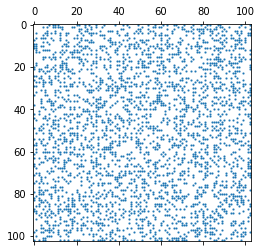

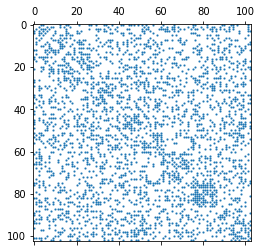

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1], dtype=torch.int16)


In [3]:
#Plot Adj matrix

W = data.W
plt.spy(W,precision=0.01, markersize=1)
plt.show()

idx = np.argsort(data.rand_idx) 
W = data.W
W2 = W[idx,:]
W2 = W2[:,idx]
plt.spy(W2,precision=0.01, markersize=1)
plt.show()

target = data.node_label
target = target[idx]
print(target)


{'nb_clusters': 5, 'size_min': 5, 'size_max': 35, 'p': 0.5, 'q': 0.35, 'p_pattern': 0.5, 'q_pattern': 0.5, 'vocab_size': 3, 'size_subgraph_min': 5, 'size_subgraph_max': 35}
pattern: 0
pattern: 1
pattern: 2
pattern: 3
pattern: 4
pattern: 5
pattern: 6
pattern: 7
pattern: 8
pattern: 9
pattern: 10
pattern: 11
pattern: 12
pattern: 13
pattern: 14
pattern: 15
pattern: 16
pattern: 17
pattern: 18
pattern: 19
pattern: 20
pattern: 21
pattern: 22
pattern: 23
pattern: 24
pattern: 25
pattern: 26
pattern: 27
pattern: 28
pattern: 29
pattern: 30
pattern: 31
pattern: 32
pattern: 33
pattern: 34
pattern: 35
pattern: 36
pattern: 37
pattern: 38
pattern: 39
pattern: 40
pattern: 41
pattern: 42
pattern: 43
pattern: 44
pattern: 45
pattern: 46
pattern: 47
pattern: 48
pattern: 49
pattern: 50
pattern: 51
pattern: 52
pattern: 53
pattern: 54
pattern: 55
pattern: 56
pattern: 57
pattern: 58
pattern: 59
pattern: 60
pattern: 61
pattern: 62
pattern: 63
pattern: 64
pattern: 65
pattern: 66
pattern: 67
pattern: 68
pattern: 

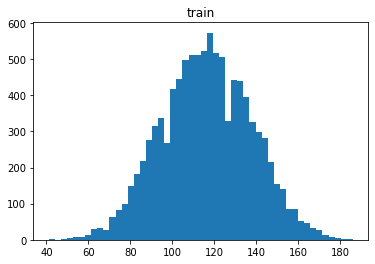

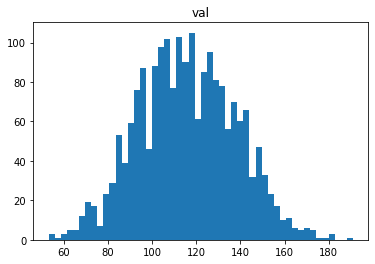

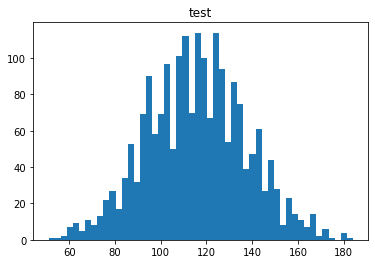

Time (sec): 257.9034593105316


In [4]:
# Generate and save SBM graphs

class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self

def plot_histo_graphs(dataset, title):
    # histogram of graph sizes
    graph_sizes = []
    for graph in dataset:
        graph_sizes.append(graph.nb_nodes)
    plt.figure(1)
    plt.hist(graph_sizes, bins=50)
    plt.title(title)
    plt.show()

    


start = time.time()


# configuration for 100 patterns 100/20 
nb_pattern_instances = 100 # nb of patterns
nb_train_graphs_per_pattern_instance = 100 # train per pattern
nb_test_graphs_per_pattern_instance = 20 # test, val per pattern

# # debug
# nb_pattern_instances = 10 # nb of patterns
# nb_train_graphs_per_pattern_instance = 10 # train per pattern
# nb_test_graphs_per_pattern_instance = 2 # test, val per pattern
# # debug

SBM_parameters = {}
SBM_parameters['nb_clusters'] = 5 
SBM_parameters['size_min'] = 5 
SBM_parameters['size_max'] = 35 
#SBM_parameters['p'] = 0.5 # v1
#SBM_parameters['q'] = 0.2 # v1
#SBM_parameters['p'] = 0.5 # v2
#SBM_parameters['q'] = 0.5 # v2
#SBM_parameters['p'] = 0.5; SBM_parameters['q'] = 0.25 # v3
SBM_parameters['p'] = 0.5; SBM_parameters['q'] = 0.35 # v4
SBM_parameters['p_pattern'] = 0.5 
SBM_parameters['q_pattern'] = 0.5  
SBM_parameters['vocab_size'] = 3 
#SBM_parameters['size_subgraph'] = 20 # v1
SBM_parameters['size_subgraph_min'] = 5 # v2
SBM_parameters['size_subgraph_max'] = 35 # v2
print(SBM_parameters)
    

dataset_train = []
dataset_val = []
dataset_test = []
for idx in range(nb_pattern_instances):
    
    print('pattern:',idx)
    
    #SBM_parameters['W0'] = random_pattern(SBM_parameters['size_subgraph'],SBM_parameters['p']) # v1
    #SBM_parameters['u0'] = np.random.randint(SBM_parameters['vocab_size'],size=SBM_parameters['size_subgraph']) # v1
    size_subgraph = np.random.randint(SBM_parameters['size_subgraph_min'],SBM_parameters['size_subgraph_max'],size=1)[0] # v2
    SBM_parameters['W0'] = random_pattern(size_subgraph,SBM_parameters['p']) # v2
    SBM_parameters['u0'] = np.random.randint(SBM_parameters['vocab_size'],size=size_subgraph) # v2
    
    for _ in range(nb_train_graphs_per_pattern_instance):
        data = generate_SBM_graph(SBM_parameters)
        graph = DotDict()
        graph.nb_nodes = data.nb_nodes
        graph.W = data.W
        graph.rand_idx = data.rand_idx
        graph.node_feat = data.node_feat
        graph.node_label = data.node_label
        dataset_train.append(graph)

    for _ in range(nb_test_graphs_per_pattern_instance):
        data = generate_SBM_graph(SBM_parameters)
        graph = DotDict()
        graph.nb_nodes = data.nb_nodes
        graph.W = data.W
        graph.rand_idx = data.rand_idx
        graph.node_feat = data.node_feat
        graph.node_label = data.node_label
        dataset_val.append(graph)

    for _ in range(nb_test_graphs_per_pattern_instance):
        data = generate_SBM_graph(SBM_parameters)
        graph = DotDict()
        graph.nb_nodes = data.nb_nodes
        graph.W = data.W
        graph.rand_idx = data.rand_idx
        graph.node_feat = data.node_feat
        graph.node_label = data.node_label
        dataset_test.append(graph)


print(len(dataset_train),len(dataset_val),len(dataset_test))


plot_histo_graphs(dataset_train,'train')
plot_histo_graphs(dataset_val,'val')
plot_histo_graphs(dataset_test,'test')


with open('SBM_PATTERN_train.pkl',"wb") as f:
    pickle.dump(dataset_train,f)
with open('SBM_PATTERN_val.pkl',"wb") as f:
    pickle.dump(dataset_val,f)
with open('SBM_PATTERN_test.pkl',"wb") as f:
    pickle.dump(dataset_test,f)
    
    
print('Time (sec):',time.time() - start) # 163s
